
# <center> Решение задачи регрессии </center>



Сегодня мы будем работать с датасетом __bikes_rent.csv__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

In [41]:
# добавляем библиотеки
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')  # правильный (наиболее красивый) стиль у графиков
%matplotlib inline

Подгрузим наши данные и посмотрим на них:

In [42]:
# в переменную df запишем данные, которые открыли из файла с помошью метода read_csv()
df = pd.read_csv('data/bikes_rent (2).csv')
# выводим первые пять строк с помощью метода head()
df.head( )

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


__Описание пееменных:__

* `season`  1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`  0 - 2011, 1 - 2012
* `mnth`  от 1 до 12
* `holiday`  0 - нет праздника, 1 - есть праздник
* `weekday`  от 0 до 6
* `workingday`  0 - нерабочий день, 1 - рабочий день
* `weathersit`  оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`  температура в Цельсиях
* `atemp`  температура по ощущениям в Цельсиях
* `hum`  влажность
* `windspeed(mph)`  скорость ветра в милях в час
* `windspeed(ms)`  скорость ветра в метрах в секунду
* `cnt`  количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

##  Изучаем данные

Давайте посмотрим, есть ли пропущенные значения:

In [43]:
# применяем метод isnull(), которые заменяет пропуски на True и обычные значения (не пропуски) на False
df.isnull()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,False,False,False,False,False,False,False,False,False,False,False,False,False
727,False,False,False,False,False,False,False,False,False,False,False,False,False
728,False,False,False,False,False,False,False,False,False,False,False,False,False
729,False,False,False,False,False,False,False,False,False,False,False,False,False


In [44]:
# Суммируем все пропуски и смотрим на количество пропусков по столбцам
df.isnull().sum()

season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp             0
hum               0
windspeed(mph)    0
windspeed(ms)     0
cnt               0
dtype: int64

Можно видеть, что пропусков нет. Нам повезло!

Для удобства давайте разделим категориальные и числовые переменные (так как для них будет разная предобработка и разные методы визуализации, а также отделим целевую переменную:

In [45]:
# категориальные переменные 
var_cat = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# непрерывные переменные
var_real = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# определяем целевую переменную
target = 'cnt'

## Исследование на наличие мультиколлинеарности

Мультиколлинеарность — сильная корреляционная связь между признаками, отбираемыми для обучения. 
Сильно скоррелированные признаки сообщают для модели одну и ту же информацию. Поэтому для обучения не нужно использовать их все. Часть из них необходимо удалить из набора данных. 

Для того, чтобы изучить, наблюдается ли в данных мультиколлинеарность, необходимо построить матрицу корреляций. Строить мы ее будем, разумеется, только для числовых признаков.

In [46]:
# отбираем только числовые колонки и с помощью метода corr() выводим корреляционную матрицу
df[var_real+[target]].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


Можно также представить результаты в визуальном виде:

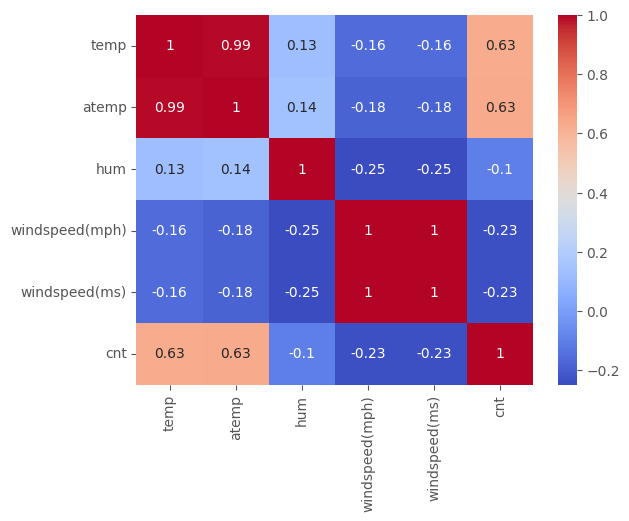

In [47]:
# выводим матрицу корреляций в виде тепловой карты
# используем метод heatmap() из библиотеки seaborn
# с помощью cmap='coolwarm' настраиваем цветовую схему
# annot = True отвечает за то, что подписаны значения корреляций
sns.heatmap(df[var_real+[target]].corr(), cmap='coolwarm', annot = True);

Из набора нескольких коррелирующих признаков следует оставлять один. Поэтому оставим среди числовых признаков только те, которые слабо коррелируют между собой. То есть, надо удалить один из признаков temp и atemp. Удалим реальную температуру и оставим atemp.

In [48]:
# выводим размерность таблицы с помощью атрибута shape
# 731 строка
# 13 столбцов
df.shape

(731, 13)

In [49]:
# записываем в переменную matrix матрицу корреляций для признаков
matrix = df.corr()

In [50]:
# выводим ранг матрицы корреляций
print('Rank:', np.linalg.matrix_rank(matrix))
# выводим определитель матрицы корреляций
print('Determinant: {:.4f}'.format(np.linalg.det(matrix)))

Rank: 12
Determinant: 0.0000


In [51]:
# с помощью метода drop() удаляем скорость ветра в милях в час
#  axis=1 показывает, что удаляем столбец
# inplace=True показывает, что перезаписываем результат
df.drop('windspeed(mph)', axis=1, inplace=True)

In [52]:
# с помощью метода drop() удаляем температуру
df.drop('temp', axis=1, inplace=True)

In [53]:
# выводим размерность оставшейся таблицы
df.shape

(731, 11)

## Обработка категориальных признаков 

Как эти признаки мешают просто взять и запустить LinearRegression? Дело в том, что некоторых из этих признаков содержат числа, которые не несут содержательного смысла (например, день недели). Значит, их нужно перекодировать.

Для этого нам понадобятся дамми-переменные.
Как ввести дамми-переменную в модель?
Как правило, это переменная, которая принимает только два
возможных значения: 0 или 1 (дихотомическая, бинарная).
При этом 0 означает отсутствие признака у данного
объекта; 1 – наличие признака. 

Например, для дня недели это будет выглядеть следующим образом:

<a href="https://imgbb.com/"><img src="https://i.ibb.co/pWv0VcP/sadxa.jpg" alt="sadxa" border="0"></a>

Давайте сделаем это OHE-кодирование. Сколько свежих OHE-признаков у нас появилось? 

In [54]:
df[var_cat] = df[var_cat].astype(str)  # чтобы все категории стали object
df.info() # выводим информацию про таблицу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         731 non-null    object 
 1   yr             731 non-null    object 
 2   mnth           731 non-null    object 
 3   holiday        731 non-null    object 
 4   weekday        731 non-null    object 
 5   workingday     731 non-null    object 
 6   weathersit     731 non-null    object 
 7   atemp          731 non-null    float64
 8   hum            731 non-null    float64
 9   windspeed(ms)  731 non-null    float64
 10  cnt            731 non-null    int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 62.9+ KB


In [55]:
df.shape # выводим размерность таблицы

(731, 11)

In [56]:
# в переменную dff записываем таблицу, которая получится, если добавить дамми-переменные
# дамми-переменные добавляем с помощью метода get_dummies(), удаляем одну колонку и не создаем колонку для пропусков
dff = pd.get_dummies(df, drop_first=True, dummy_na=False)
dff.head() # выводим первые 5 строк

,atemp,hum,windspeed(ms),cnt,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,18.18125,80.5833,4.805490,985,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,17.68695,69.6087,7.443949,801,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,9.47025,43.7273,7.437060,1349,False,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,10.60610,59.0435,4.800998,1562,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,False,False
4,11.46350,43.6957,5.597810,1600,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [57]:
dff.shape # выводим размерность получившейся таблицы

(731, 29)

Теперь определим целевую переменую:

In [58]:
y = dff['cnt'] # то, что прогнозируем, записываем в переменную у

А в качестве предикторов (признаков) возьмем все, кроме целевой переменной:

In [59]:
X = dff.drop('cnt', axis=1) # то, с помощью чего прогнозируем, записываем в переменную х

Посмотрим, какие признаки у нас будут отвечать за предсказание аренды:

In [60]:
X.info() # выводим информацию про таблицу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atemp          731 non-null    float64
 1   hum            731 non-null    float64
 2   windspeed(ms)  731 non-null    float64
 3   season_2       731 non-null    bool   
 4   season_3       731 non-null    bool   
 5   season_4       731 non-null    bool   
 6   yr_1           731 non-null    bool   
 7   mnth_10        731 non-null    bool   
 8   mnth_11        731 non-null    bool   
 9   mnth_12        731 non-null    bool   
 10  mnth_2         731 non-null    bool   
 11  mnth_3         731 non-null    bool   
 12  mnth_4         731 non-null    bool   
 13  mnth_5         731 non-null    bool   
 14  mnth_6         731 non-null    bool   
 15  mnth_7         731 non-null    bool   
 16  mnth_8         731 non-null    bool   
 17  mnth_9         731 non-null    bool   
 18  holiday_1 

## Время регрессии

In [61]:
X.info() # выводим информацию про таблицу

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   atemp          731 non-null    float64
 1   hum            731 non-null    float64
 2   windspeed(ms)  731 non-null    float64
 3   season_2       731 non-null    bool   
 4   season_3       731 non-null    bool   
 5   season_4       731 non-null    bool   
 6   yr_1           731 non-null    bool   
 7   mnth_10        731 non-null    bool   
 8   mnth_11        731 non-null    bool   
 9   mnth_12        731 non-null    bool   
 10  mnth_2         731 non-null    bool   
 11  mnth_3         731 non-null    bool   
 12  mnth_4         731 non-null    bool   
 13  mnth_5         731 non-null    bool   
 14  mnth_6         731 non-null    bool   
 15  mnth_7         731 non-null    bool   
 16  mnth_8         731 non-null    bool   
 17  mnth_9         731 non-null    bool   
 18  holiday_1 

In [62]:
X1 = X.astype(float) # преобразуем все колонки в данные типа float

In [63]:
X1 # смотрим, что записано в Х1

,atemp,hum,windspeed(ms),season_2,season_3,season_4,yr_1,mnth_10,mnth_11,mnth_12,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,18.18125,80.5833,4.805490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,17.68695,69.6087,7.443949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9.47025,43.7273,7.437060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10.60610,59.0435,4.800998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,11.46350,43.6957,5.597810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,11.33210,65.2917,10.486773,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
727,12.75230,59.0000,4.656485,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
728,12.12000,75.2917,3.725374,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
729,11.58500,48.3333,10.505372,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
X1.shape[0] # выводим количество строк в Х1

731

In [65]:
n = X1.shape[0] # записываем количество строк в Х1 в переменную n
X1 = np.column_stack((np.ones(n), X1)) # прицепляем к Х1 столбец с единицами
w_hat = np.linalg.inv(X1.T@X1)@X1.T@np.array(y) # в переменную w_hat записываем оцененные коэффициенты регрессии

In [66]:
w_hat # выводим оцененные коэффициенты регрессии

array([ 1863.15626233,   126.00923291,    -8.31243272,   -81.28132264,
        1013.75870783,   837.18875694,  1743.81419718,  2014.84511557,
          64.7470699 ,  -564.28922585,  -446.22771476,   171.99262551,
         267.09107164,   -26.26556676,   181.3909513 ,   -59.67095146,
        -690.64621976,   -54.30823899,   371.61431102, -5386.14072576,
        3520.54811119,  4553.76186656,  2076.56592701,  5446.86422257,
        5177.86772669,   444.32101015, -6862.95322871,  -467.09679617,
       -1955.7679963 ])

In [67]:
y_pred = X1 @ w_hat # вычисляем предсказание 

In [68]:
y_pred # выводим предсказание 

array([ 3070.9459679 ,  2441.10684556, -1253.88422182,     9.4048558 ,
       -2296.93912971,  1267.54928754,   201.46457762,  1767.72891849,
        1353.06741305, -1473.53705349,  -574.67913658, -3152.14182198,
         273.90155175,   610.02152479,  2604.46614105,  2477.98818846,
        -274.91079659,  -522.89698361, -2633.83285119,   662.50042971,
         -67.40310037,  2054.50381191,  1522.69864287, -1530.43548231,
        -264.33212532, -5028.53339303,   982.66926155,   158.59569812,
        2748.33255835,  2659.89173342, -1730.45601802,   -82.60633202,
       -2903.39353995,   699.66211583,   525.49578469,  2379.24927422,
        3055.18386031,  -118.34889646,  -353.28762534, -3180.2884923 ,
         657.41492384,  1010.09821368,  2999.76714705,  3061.90247221,
        -127.24912121,   357.36810413, -1724.01647517,  2339.8502838 ,
        2501.3719054 ,  3553.90138264,  2900.00045159,   239.92745124,
         -58.60184499, -1783.8722455 ,   784.4801208 ,   655.41344765,
      

In [69]:
y # целевая переменная

0       985
1       801
2      1349
3      1562
4      1600
       ... 
726    2114
727    3095
728    1341
729    1796
730    2729
Name: cnt, Length: 731, dtype: int64

Выясним точность наших предсказаний:

In [70]:
from sklearn.metrics import mean_squared_error # импортируем функцию для вычисления MSE

def rmse(y_test, y_pred): # определяем функцию для поиска RMSE
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [71]:
rmse(y, y_pred) # вычисляем значение ошибки RMSE

2050.0118235859377

Еще давайте сделаем наивный прогноз:

In [72]:
y_mean = np.mean(y)                     # посчитали среднее 
y_pred_naive = np.ones(len(y)) * y_mean  # спрогнозировали им продажи
y_pred_naive[:5] # посмотрели первые 5 значений

array([4504.34883721, 4504.34883721, 4504.34883721, 4504.34883721,
       4504.34883721])

In [73]:
rmse(y, y_pred_naive) # вычисляем значение ошибки RMSE

1935.8859561152221

  Теперь будем использовать для предсказания линейную регрессию из готовой библиотеки:

In [74]:
from sklearn.linear_model import LinearRegression

# Объявили модель
model = LinearRegression()

# Обучили модель 
model.fit(X, y)

# Сделали прогнозы 
y_pred = model.predict(X)

Оценим качество:

In [75]:
rmse(y, y_pred) # вычисляем значение ошибки RMSE

756.0689821350974

### Полиномиальная регрессия и регуляризация

In [76]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [77]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X)
print('Количество факторов: {}'.format(X_poly.shape[1]))

lr = LinearRegression()
lr.fit(X_poly, y)

cv_results = cross_validate(lr, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.1f}'.format(-cv_results['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.1f}'.format(-cv_results['test_score'].mean() * 100))


Количество факторов: 4494


MAPE на тренировочных фолдах: 0.0
MAPE на валидационных фолдах: 304.3


In [78]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

lasso = Lasso(alpha=5)
lasso.fit(X_poly, y)

# оцениваем качество модели на кросс-валидации
cv_results = cross_validate(lasso, X_poly, y, scoring='neg_mean_absolute_percentage_error', cv=5, return_train_score=True)
print('MAPE на тренировочных фолдах: {:.1f}'.format(-cv_results['train_score'].mean() * 100))
print('MAPE на валидационных фолдах: {:.1f}'.format(-cv_results['test_score'].mean() * 100))


c:\Users\smart\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.356e+06, tolerance: 2.740e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\smart\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.698e+06, tolerance: 1.741e+05
  model = cd_fast.enet_coordinate_descent(
c:\Users\smart\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

MAPE на тренировочных фолдах: 5.2
MAPE на валидационных фолдах: 55.6


c:\Users\smart\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.710e+06, tolerance: 1.875e+05
  model = cd_fast.enet_coordinate_descent(
